In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [2]:
img_path = [] 
img_path.append('./images/karina_mask.jpg')
img_path.append('./images/cat.jpg')
img_path.append('./images/sea.jpg')

In [3]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f3106737670>)

In [4]:
#model define
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

#Pascal dataset labels
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

#color palette
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [5]:
def semantic_seg(model, img_orig, path, background=''):
    
    seg_val, pred = model.segmentAsPascalvoc(path)
    pred = cv2.resize(pred, (500,500))
    palette = colormap[seg_val['class_ids'][1]][::-1] #BGR -> RGB
    seg_map = np.all(pred==palette, axis=-1)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) #imgmask convert gray -> BGR
    img_bg_mask = cv2.bitwise_not(img_mask_color)#extract background only
    if background:
        bg = cv2.imread(background)
        bg = cv2.resize(bg, (500,500))
        img_bg = cv2.blur(bg, (13,13))
        img_bg_blur = cv2.bitwise_and(img_bg, img_bg_mask)#erase only the human image
    else:
        img_bg_blur = cv2.blur(img_orig, (13,13)) 
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

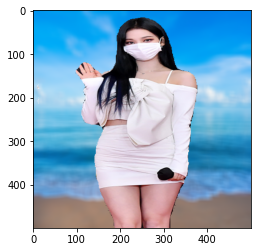

In [6]:
img_orig = cv2.imread(img_path[0])
img_orig = cv2.resize(img_orig, (500,500))
cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

semantic_seg(model, img_orig, img_path[0], img_path[2])

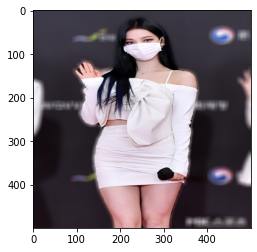

In [7]:
img_orig = cv2.imread(img_path[0])
img_orig = cv2.resize(img_orig, (500,500))
cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

semantic_seg(model, img_orig, img_path[0])

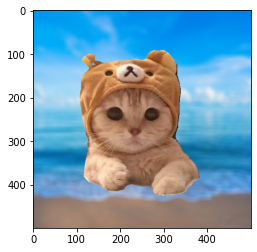

In [8]:
img_orig = cv2.imread(img_path[1])
img_orig = cv2.resize(img_orig, (500,500))
cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

semantic_seg(model, img_orig, img_path[1], img_path[2])

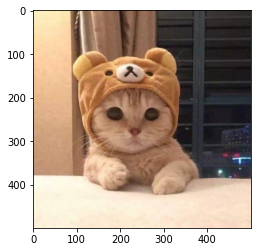

In [9]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

## 문제점
- 원본 이미지와 비교했을 때 모자의 귀부분을 고양이의 귀로 인식했다.
- 하지만 인식을 할 경우 제대로 해야하는데 왼쪽의 고양이 귀는 잘린 상태로 segmentation이 된 것을 확인할 수 있다.
- 배경과 분리가 잘 되지 않은 것으로 보임

## 해결방안
- struct2Depth를 활용한다.
- 깊이를 기준으로 masking 영역을 정하면 뒤쪽의 배경과 앞쪽의 피사체를 조금 더 잘 분리할 수 있을 것으로 예상된다.